<a href="https://colab.research.google.com/github/hannakb/Neurons-Importance/blob/master/MI_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch

In [2]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
  
print(device)

cuda


In [0]:
torch.cuda.set_device(0)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm import tqdm_notebook as tqdm
   
def train(model, train_loader, optimizer, epoch, log=True):
    model.train()
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if log and batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, test_loader, log=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    if (log):
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    else:
        return correct / len(test_loader.dataset)

In [5]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, pin_memory=True)
    

0it [00:00, ?it/s]

170500096it [00:04, 41097465.78it/s]                               


Extracting ../data/cifar-10-python.tar.gz to ../data


In [0]:
from scipy.stats import entropy
def entropy_calc(layers, data_loader):
    prob = 0
    if isinstance(layers[-1], nn.ReLU):
      threshold = 0
    elif isinstance(layers[-1], nn.Sigmoid) or isinstance(layers[-1], nn.Tanh):
      threshold = 0.5
    for data, target in data_loader:
        prob += (layers(data.to(device)) > threshold).sum(0, dtype=torch.float64)
    return entropy(torch.stack([prob, len(data_loader.dataset) - prob]).cpu())

In [0]:
from scipy.stats import entropy
def cond_entropy_calc(layers, data_loader, y):
    prob = 0
    if isinstance(layers[-1], nn.ReLU):
      threshold = 0
    elif isinstance(layers[-1], nn.Sigmoid) or isinstance(layers[-1], nn.Tanh):
      threshold = 0.5
    sample_size = 0
    for data, target in data_loader:
        prob += (target.to(device) == y).view(1, -1).float() @ ((layers(data.to(device)) > threshold)).float()
        sample_size += (target == y).sum()
    return entropy(torch.stack([prob, sample_size - prob]).cpu()).flatten()

In [0]:
from collections import Counter
from scipy.stats import entropy
def mutual_information(layers, data_loader, out_size=100):
  if isinstance(layers[-1], nn.ReLU):
    threshold = 0
  elif isinstance(layers[-1], nn.Sigmoid) or isinstance(layers[-1], nn.Tanh):
    threshold = 0.5
  probs = torch.zeros((10, out_size)).to(device)
  for data, target in data_loader:
    output = layers(data.to(device))
    for o, t in zip(output, target):
      probs[t] += (o > threshold).float()
  all_probs = probs.sum(0) / len(data_loader.dataset)
  all_entropy = entropy(torch.stack([all_probs, 1 - all_probs]).cpu().numpy())

  classes_number = torch.Tensor(list(Counter(data_loader.dataset.targets).values())).to(device) #.numpy()
  cond_prob = torch.div(probs.t(), classes_number.view(1, -1))
  cond_ent_matrix = entropy(torch.stack([cond_prob, 1 - cond_prob]).cpu().numpy())

  cond_entorpy = cond_ent_matrix @ (classes_number.cpu().numpy() / len(data_loader.dataset))

  return (all_entropy - cond_entorpy), all_entropy

$$H(L) = -\sum p_{binned}(L)\log p_{binned}(L) $$

$$H(L|Y) = -\sum_{L, y} p(L, y)\log p(L|) = -\sum_y p(y)\sum_L p(L|y)\log p(L|y)  $$

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.seq = nn.Sequential(
            self.Flatten(),
            nn.Linear(784, 100),
            nn.BatchNorm1d(100),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1)
        )
        
    class Flatten(nn.Module):
        def forward(self, x):
            return x.view(x.shape[0], -1)

    def forward(self, x):
        return self.seq(x)

In [0]:
# 3072 − 250 − 500 − 250 − 500 − 10
# [0.2, 0.4, 0.2, 0.4]
class Net_CIFAR(nn.Module):
    def __init__(self):
        super(Net_CIFAR, self).__init__()
        self.seq = nn.Sequential(
            self.Flatten(),
            nn.Linear(3072, 250),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.Dropout(p=0.4),
            nn.ReLU(),
            nn.Linear(500, 10),
            nn.LogSoftmax(dim=1)
        )
        
    class Flatten(nn.Module):
        def forward(self, x):
            return x.view(x.shape[0], -1)

    def forward(self, x):
        return self.seq(x)

In [80]:
epochs = 10

model = Net_CIFAR().to(device)
optimizer = optim.Adam(model.parameters())

layers_ind = [4, 7, 10, 13]
entropy_layers = [[] for _ in layers_ind]
MI_layers = [[] for _ in layers_ind]

for ind, n_layer in enumerate(layers_ind):
  mi, h = mutual_information(model.seq[:n_layer], test_loader, model.seq[n_layer].in_features)
  entropy_layers[ind].append(h)
  MI_layers[ind].append(mi)

for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, epoch, log=False)
    test(model, test_loader)
    for ind, n_layer in enumerate(layers_ind):
      mi, h = mutual_information(model.seq[:n_layer], test_loader, model.seq[n_layer].in_features)
      entropy_layers[ind].append(h)
      MI_layers[ind].append(mi)




Test set: Average loss: 1.8319, Accuracy: 3324/10000 (33%)





Test set: Average loss: 1.8161, Accuracy: 3377/10000 (34%)





Test set: Average loss: 1.7386, Accuracy: 3731/10000 (37%)





Test set: Average loss: 1.7272, Accuracy: 3911/10000 (39%)





Test set: Average loss: 1.8107, Accuracy: 3277/10000 (33%)





Test set: Average loss: 1.6858, Accuracy: 3951/10000 (40%)





Test set: Average loss: 1.7354, Accuracy: 3904/10000 (39%)





Test set: Average loss: 1.6862, Accuracy: 3988/10000 (40%)





Test set: Average loss: 1.7181, Accuracy: 3915/10000 (39%)





Test set: Average loss: 1.6814, Accuracy: 4087/10000 (41%)



In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

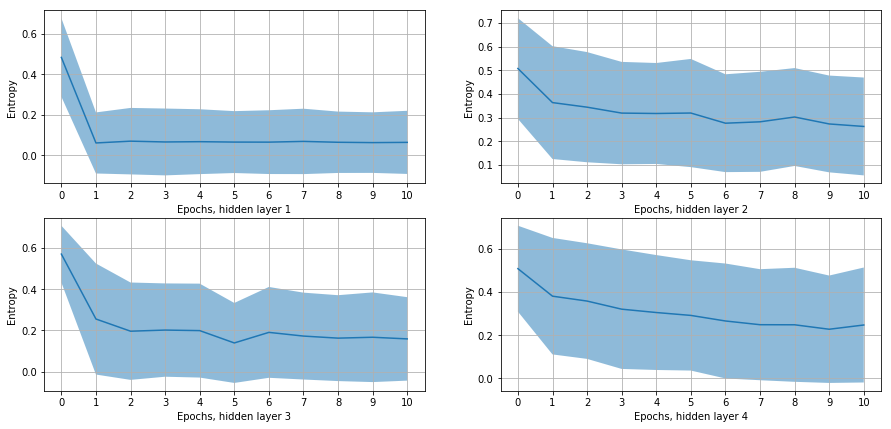

In [87]:
plt.figure(figsize=(15,7))
for ind, n_layer in enumerate(layers):
  plt.subplot(2, 2, ind + 1)
  mean = np.mean(entropy_layers[ind], 1)
  var = np.std(entropy_layers[ind], 1)
  plt.plot(mean)
  plt.fill_between(np.arange(epochs + 1), mean - var, mean + var, alpha=0.5)
  plt.xticks(np.arange(0, epochs + 1))
  plt.xlabel("Epochs, hidden layer {}".format(ind + 1))
  plt.ylabel("Entropy")
  plt.grid()

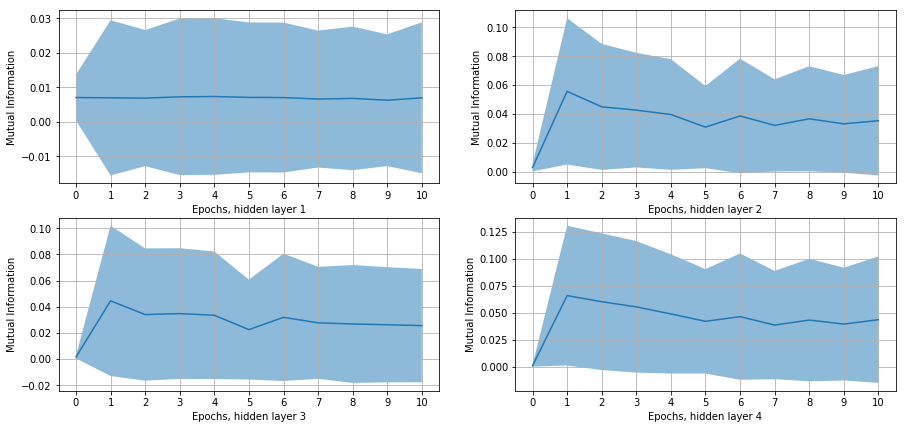

In [89]:
plt.figure(figsize=(15,7))
for ind, n_layer in enumerate(layers):
  plt.subplot(2, 2, ind + 1)
  mean = np.mean(MI_layers[ind], 1)
  var = np.std(MI_layers[ind], 1)
  plt.plot(mean)
  plt.fill_between(np.arange(epochs + 1), mean - var, mean + var, alpha=0.5)
  plt.xticks(np.arange(0, epochs + 1))
  plt.xlabel("Epochs, hidden layer {}".format(ind + 1))
  plt.ylabel("Mutual Information")
  plt.grid()

Ablating neurons at 4th layer

In [0]:
from copy import deepcopy
import numpy as np
model_ent = deepcopy(model)
acc_mi_ablating = []
for neuron in np.argsort(MI_layers[3][-1]):
    model_ent.seq[10].weight[neuron] = 0
    acc_mi_ablating.append(test(model_ent, test_loader, log=False))

In [0]:
model_rand = deepcopy(model)
acc_rand_ablating = []
neurons_idx = np.arange(500)
np.random.shuffle(neurons_idx)
for neuron in neurons_idx:
    model_rand.seq[10].weight[neuron] = 0
    acc_rand_ablating.append(test(model_rand, test_loader, log=False))

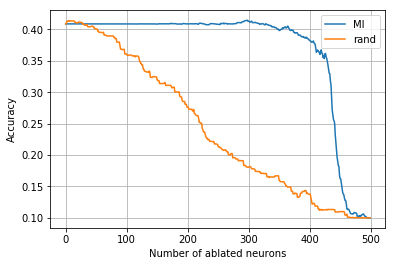

In [103]:
plt.plot(acc_mi_ablating, label="MI")
plt.plot(acc_rand_ablating, label="rand")
plt.ylabel("Accuracy")
plt.xlabel("Number of ablated neurons")
plt.legend()
plt.grid()

In [0]:
from copy import deepcopy
import numpy as np
model_ent = deepcopy(model)
acc_mi_ablating = []
for neuron in np.argsort(MI_layers[2][-1]):
    model_ent.seq[7].weight[neuron] = 0
    acc_mi_ablating.append(test(model_ent, test_loader, log=False))
    
model_rand = deepcopy(model)
acc_rand_ablating = []
neurons_idx = np.arange(250)
np.random.shuffle(neurons_idx)
for neuron in neurons_idx:
    model_rand.seq[7].weight[neuron] = 0
    acc_rand_ablating.append(test(model_rand, test_loader, log=False))

In [0]:
plt.plot(acc_mi_ablating, label="MI")
plt.plot(acc_rand_ablating, label="rand")
plt.ylabel("Accuracy")
plt.xlabel("Number of ablated neurons")
plt.legend()
plt.grid()